In [1]:
include("XYCore.jl")
using .XYCore
using Logging, LinearAlgebra, Statistics, StatsBase, Random, ProgressMeter
using CairoMakie

println(names(XYCore))

[:XYCore, :calc_acceptance_and_rtt, :calc_energy, :calc_magnetization, :initial_state, :metropolis_sampler, :score_method, :wolff_sampler]


In [2]:
N = 20
M = 20

20

In [3]:
function run_simulation(N; mcSteps=10^3, eqSteps=10^6)
    total_sites = N * N
    βs = 0.4:0.005:2.1

    E_vals = Float64[]
    M_vals = Float64[]
    Cv_vals = Float64[]
    Chi_vals = Float64[]
    helicity_moduli = Float64[]

    @showprogress for β in βs
        config = XYCore.initial_state(N)

        for _ in 1:eqSteps
            config = XYCore.metropolis_sampler(config, β, N)
            # config = XYCore.wolff_sampler(config, β, N)
        end

        E_acc, E2_acc, M_acc, M2_acc = 0.0, 0.0, 0.0, 0.0
        E_x_acc = 0.0
        J_x_sq_acc = 0.0

        for _ in 1:mcSteps
            config = XYCore.metropolis_sampler(config, β, N)
            # config = XYCore.wolff_sampler(config, β, N)
            E = XYCore.calc_energy(config, N)
            M = XYCore.calc_magnetization(config, N)
            E_x, J_x = XYCore.calc_helicity_terms(config, N)
            E_acc += E
            E2_acc += E^2
            M_acc += M
            M2_acc += M^2
            E_x_acc += E_x
            J_x_sq_acc += J_x^2
        end

        avg_E = E_acc / mcSteps
        avg_E2 = E2_acc / mcSteps
        avg_M = M_acc / mcSteps
        avg_M2 = M2_acc / mcSteps
        avg_E_x = E_x_acc / mcSteps
        avg_J_x_sq = J_x_sq_acc / mcSteps

        energy_per_site = avg_E / total_sites
        specific_heat = (avg_E2 - avg_E^2) * β^2 / total_sites
        susceptibility = (avg_M2 - avg_M^2) * total_sites * β
        helicity = (avg_E_x / total_sites) - β * (avg_J_x_sq / total_sites)
        
        push!(E_vals, energy_per_site)
        push!(M_vals, avg_M)
        push!(Cv_vals, specific_heat)
        push!(Chi_vals, susceptibility)
        push!(helicity_moduli, helicity)
    end
    
    return βs, E_vals, M_vals, Cv_vals, Chi_vals, helicity_moduli
end

run_simulation (generic function with 1 method)

In [4]:
βs, energies, magnetizations, specific_heats, susceptibilities, helicity_moduli = run_simulation(N)
println("Simulation completed.")

Progress: 100%|█████████████████████████████████████████| Time: 4:40:53


Simulation completed.


In [5]:
dir = "../../plots/XY_model/L=$N/M=$M"
if dir !== nothing
    mkpath(dir)
end

"../../plots/XY_model/L=20/M=20"

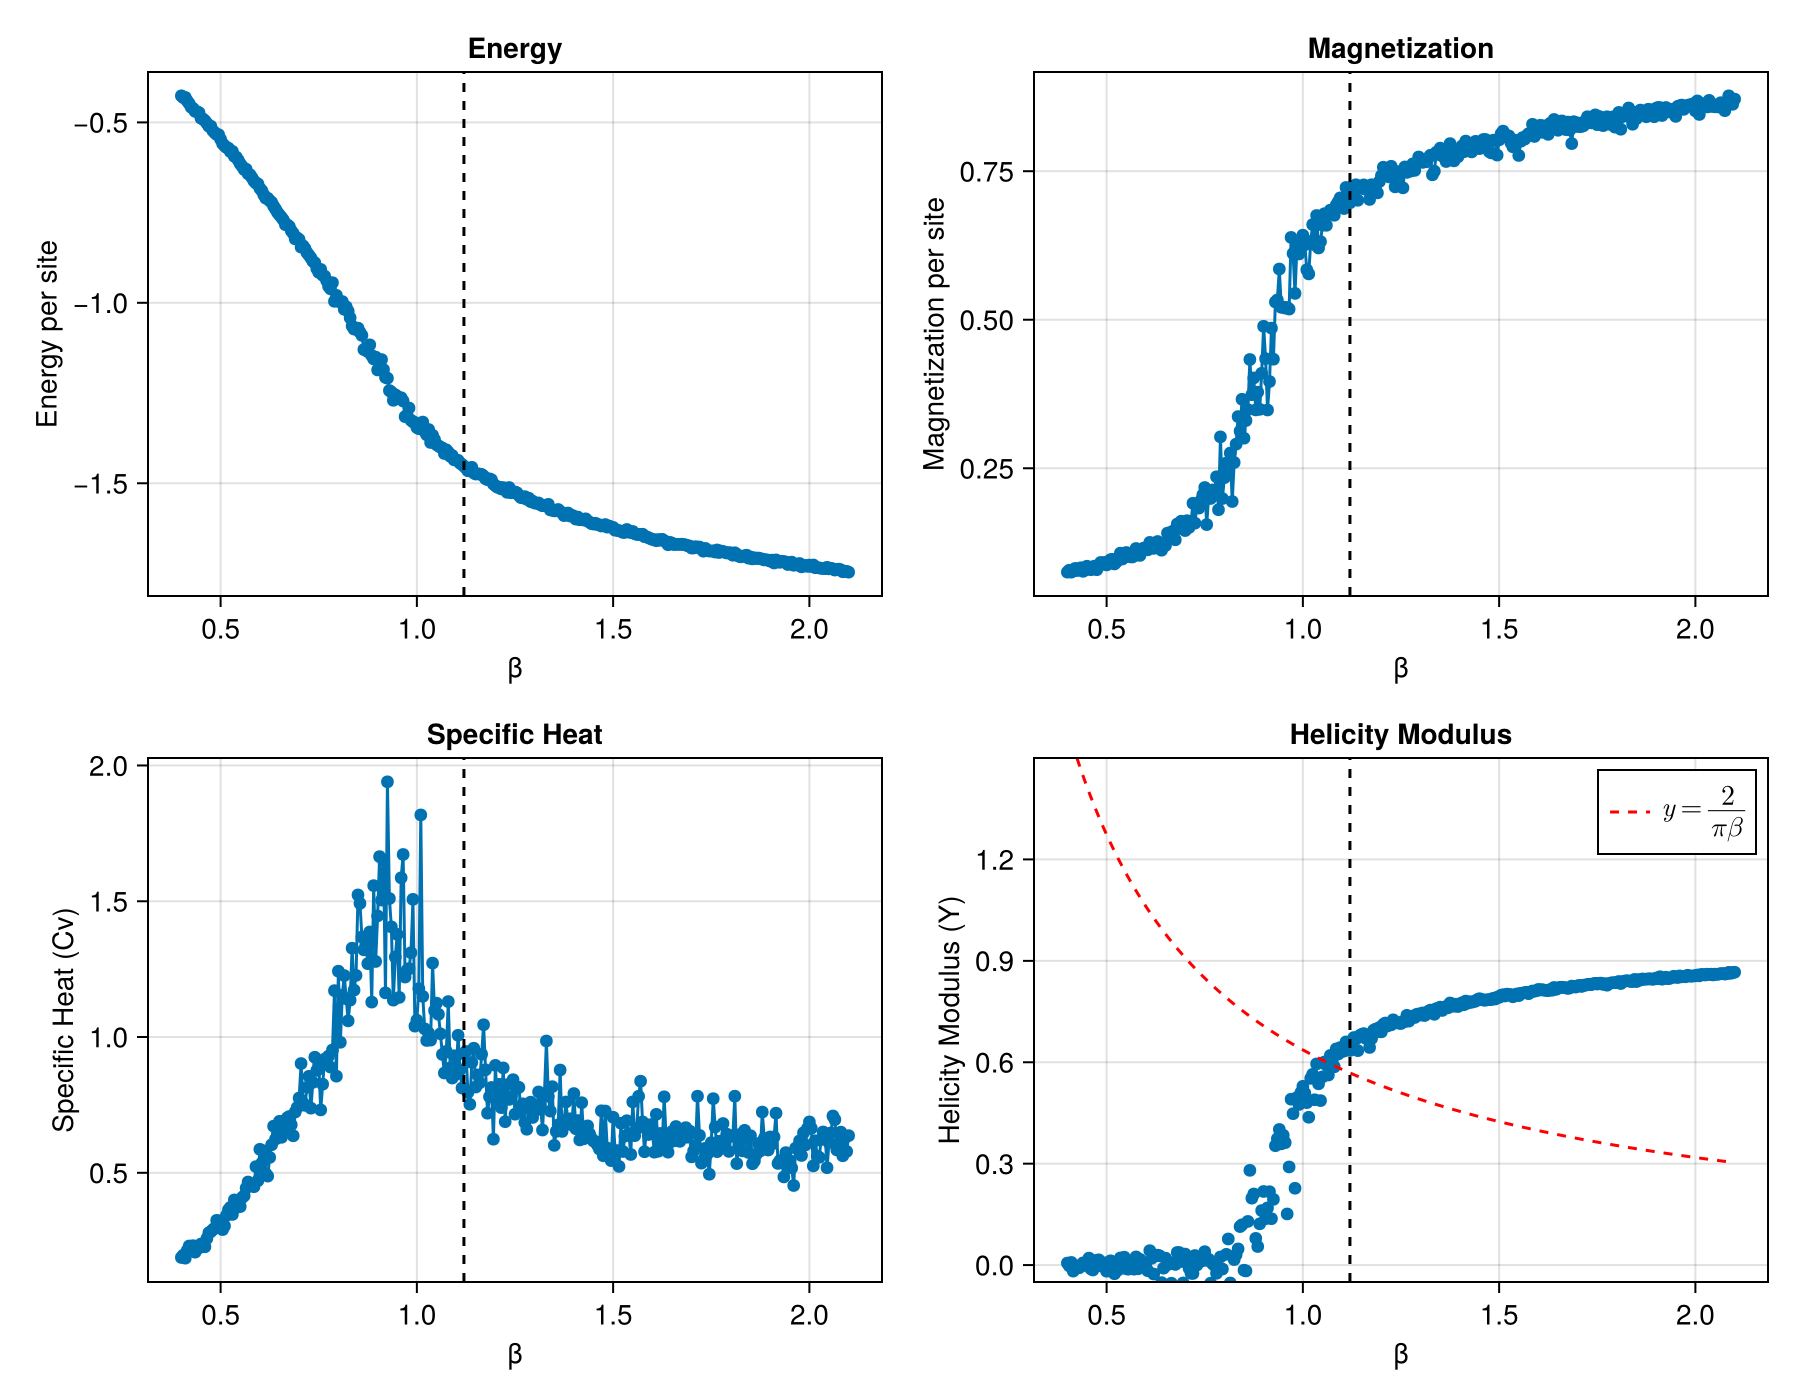

CairoMakie.Screen{IMAGE}


In [6]:
β_c = 1.1199

fig = Figure(size = (900, 700))
ax1 = Axis(fig[1, 1], xlabel = "β", ylabel = "Energy per site", title = "Energy")
scatterlines!(ax1, βs, energies)
vlines!(ax1, [β_c], color=:black, linestyle=:dash)

ax2 = Axis(fig[1, 2], xlabel = "β", ylabel = "Magnetization per site", title = "Magnetization")
scatterlines!(ax2, βs, magnetizations)
vlines!(ax2, [β_c], color=:black, linestyle=:dash)

ax3 = Axis(fig[2, 1], xlabel = "β", ylabel = "Specific Heat (Cv)", title = "Specific Heat")
scatterlines!(ax3, βs, specific_heats)
vlines!(ax3, [β_c], color=:black, linestyle=:dash)

# ax4 = Axis(fig[2, 2], xlabel = "β", ylabel = "Susceptibility (χ)", title = "Susceptibility")
# scatterlines!(ax4, βs, susceptibilities)
# vlines!(ax4, [β_c], color=:black, linestyle=:dash)

ax4 = Axis(fig[2, 2], xlabel = "β", ylabel = "Helicity Modulus (Υ)", title = "Helicity Modulus")
ylims!(ax4, -0.05, 1.5)
scatter!(ax4, βs, helicity_moduli)
lines!(ax4, βs, 2 ./ (βs .* π), color=:red, linestyle=:dash, label=L"y = \frac{2}{\pi\beta}")
vlines!(ax4, [β_c], color=:black, linestyle=:dash)
axislegend(ax4)

display(fig)

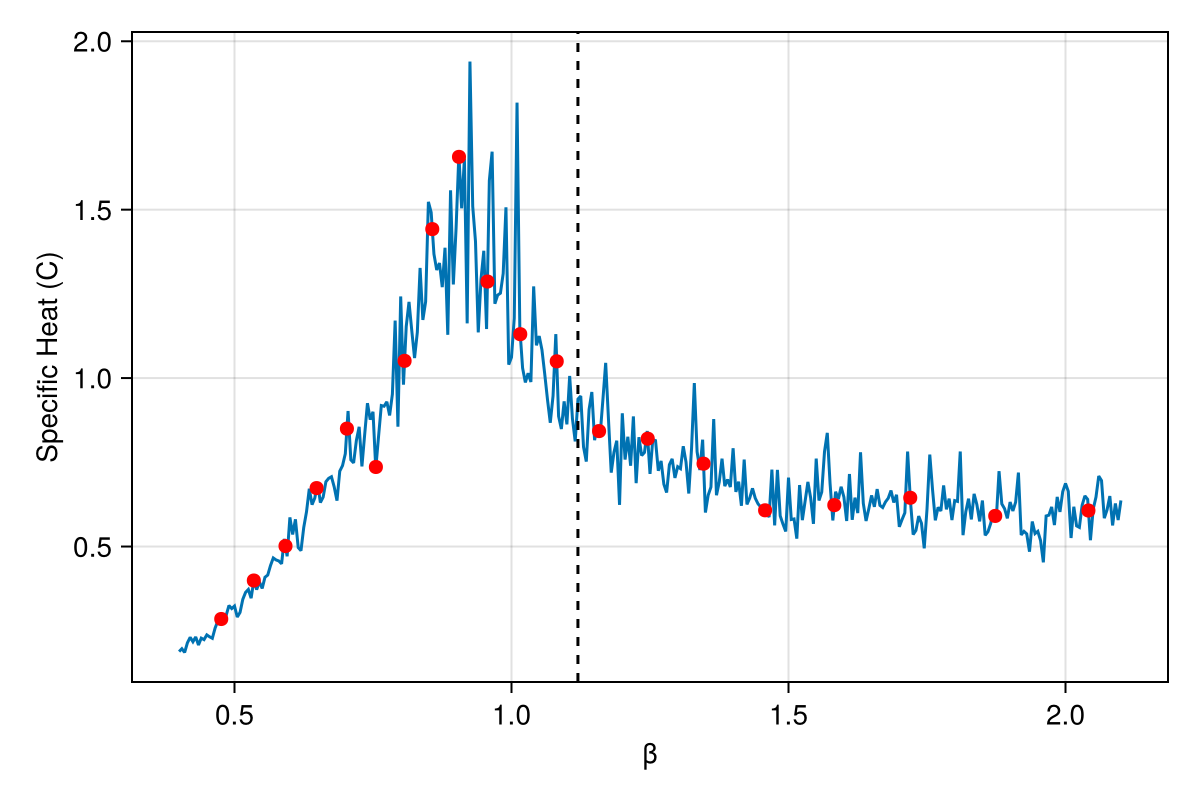

In [7]:
using Interpolations

optimized_β = [0.47608451174283384, 0.5349073876328612, 0.5920508179978864, 0.6482285148545113, 0.7029401116686586, 0.7552453038374775, 0.8070470454946345, 0.8570094449943182, 0.9052355157559144, 0.956599456247097, 1.0158025006996814, 1.081657804051085, 1.1580616307951335, 1.2458984588814268, 1.3466466568996367, 1.4577755539186685, 1.5826644083541614, 1.7197531948713185, 1.8731373192180718, 2.041366227658945]

itp = linear_interpolation(βs, specific_heats)
optimized_cvs = itp(optimized_β)

fig1 = Figure(size = (600, 400))
ax = Axis(
    fig1[1, 1], 
    xlabel = "β", 
    ylabel = "Specific Heat (C)", 
    # title = "Specific Heat"
)
lines!(ax, βs, specific_heats)
vlines!(ax, [β_c], color=:black, linestyle=:dash)
scatter!(ax, optimized_β, optimized_cvs, color = :red, markersize = 10, label = "Optimized β")
display(fig1)
save("$dir/specific_heats.png", fig1; px_per_unit=4)